In [3]:
sd_hf = model_hf.state_dict()

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math

In [2]:
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_embd: int = 768
    batch_size: int = 1
    n_layer: int = 12
    n_head: int = 12
    
config = GPTConfig

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [4]:
device

device(type='cuda')

In [5]:
class MultiHeadedMaskedSelfAttention(nn.Module):
    """
    transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
    transformer.h.0.attn.c_attn.bias torch.Size([2304])
    transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
    transformer.h.0.attn.c_proj.bias torch.Size([768])
    """
    def __init__(self, config):
        super().__init__()
        
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        
        
    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x)
        q,k,v = qkv.split(split_size=config.n_embd, dim=2)
        q = q.view(
            B, 
            T, 
            config.n_head,
            config.n_embd // config.n_head
        ).transpose(1,2)
        k = k.view(
            B, 
            T, 
            config.n_head,
            config.n_embd // config.n_head
        ).transpose(1,2)
        
        attention = (q @ k.transpose(2,3)) * (1.0 / math.sqrt(k.size(-1)))
        
        # this could be slow cause we are creating mask every time
        masked_attention = F.softmax(
            attention.masked_fill(
                ~torch.tril(torch.ones_like(attention, dtype=torch.bool, device=device)), 
                float('-inf')),
            dim=-1)
        
        v = v.view(
            B, 
            T, 
            config.n_head,
            config.n_embd // config.n_head
        ).transpose(1,2)
        
        out = masked_attention @ v
        out = out.transpose(1,2).contiguous().view(B,T,config.n_embd)
        out = self.c_proj(out)
        return out
        
class MLP(nn.Module):
    """
    transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
    transformer.h.0.mlp.c_fc.bias torch.Size([3072])
    transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
    transformer.h.0.mlp.c_proj.bias torch.Size([768])
    """
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)
        self.activation = nn.GELU(approximate='tanh')
        
    def forward(self, x):
        x = self.c_fc(x)
        x = self.activation(x)
        x = self.c_proj(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadedMaskedSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        attention = self.attn(self.ln_1(x))
        x = attention + x
        mlp = self.mlp(self.ln_2(x))
        x = mlp + x
        return x

class GPT(nn.Module):
    def __init__(self, config, device=device):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
             wte = nn.Embedding(config.vocab_size, config.n_embd),
             wpe = nn.Embedding(config.block_size, config.n_embd),
             h = nn.ModuleList(TransformerBlock(config) for _ in range(config.n_layer)),
             ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.position_input = torch.tensor(range(config.block_size), device=device)
        
    def forward(self, x, embedding=False):
        B, T = x.size()
        assert T <= self.config.block_size, f"(alex) Sequence too long! (length={T})"
        x = self.transformer.wte(x) + self.transformer.wpe(torch.arange(0, T, dtype=torch.long, device=x.device))
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        if embedding: return x
        x = self.lm_head(x)
        return x
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print(config_args)
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        
        for k in sd_keys:
            if k not in sd_keys_hf:
                print(k)
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

       

In [6]:
gpt = GPT.from_pretrained('gpt2')
gpt.to(device)


loading weights from pretrained gpt: gpt2
{'n_layer': 12, 'n_head': 12, 'n_embd': 768}


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x TransformerBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadedMaskedSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (activation): GELU(approximate='tanh')
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
gpt.transformer.wte.weight.shape

torch.Size([50257, 768])

In [11]:
gpt.lm_head.weight.shape

torch.Size([50257, 768])

In [13]:
(gpt.transformer.wte.weight == gpt.lm_head.weight).all()

tensor(True, device='cuda:0')

In [114]:
x = torch.randint(0, config.vocab_size, (config.batch_size, 1023), device=device)
x.shape
#x = gpt(x)

torch.Size([1, 1023])

In [199]:
torch.tensor(x.shape).tolist()

[1, 1023]

In [116]:
x = gpt(x)
x.shape

torch.Size([1, 1023, 50257])

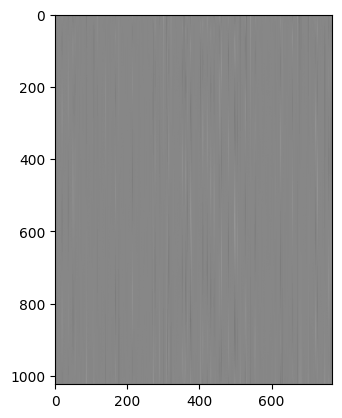

In [5]:
import matplotlib.pyplot as plt

plt.imshow(sd_hf["transformer.wpe.weight"],cmap="gray")

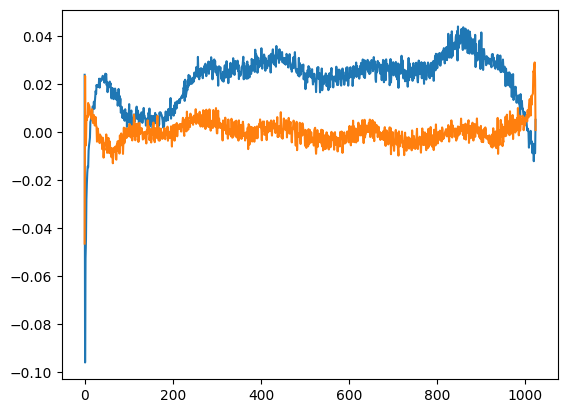

In [18]:
plt.plot(sd_hf['transformer.wpe.weight'][:, 250])
plt.plot(sd_hf['transformer.wpe.weight'][:, 150])


In [306]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
print(generator(
    "Yesterday I", 
    max_length=100, num_return_sequences=1)[0]['generated_text'])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Yesterday I have heard that some people that were told to change everything for me, as compared to the previous one, the "Growth for the future" was said to be the most important thing for this generation, by many. The first thing to do is to get that future over with. And, what people are saying, is to look at each other the same again and again and again and again, this time in a big way. But the only time we did that was to get the


In [10]:
gpt.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x TransformerBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadedMaskedSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (activation): GELU(approximate='tanh')
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [23]:
gpt.to('cuda')

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x TransformerBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadedMaskedSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (activation): GELU(approximate='tanh')
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
!nvidia-smi

Thu Feb 20 00:08:53 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   49C    P2    40W / 140W |   1407MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.8 MB/s eta 0:00:00 0:00:01


In [8]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

In [9]:
gpt.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x TransformerBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadedMaskedSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (activation): GELU(approximate='tanh')
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:

def generate(model, prompt="Hello, I'm a language model", length=20):
    
    
    with torch.no_grad():
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(prompt)
        #tokens = [220] * (target_length - len(tokens)) + tokens
        x = torch.tensor(tokens).to('cuda')
        x = x.view(1, len(tokens))
        

        for i in range(length):
            
            #print(i)
               
            y = model(x)
            #print(y.shape)
            probs = F.softmax(y[0, -1, :], dim=0)
            topk_probs, topk_ixs = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs.cpu(), 1).to(topk_probs.device)
            y= topk_ixs[ix]
            prompt += enc.decode([y[0].item()])
            x = torch.cat([x, y.view(1, 1)], dim=1)[:, 1:]
            #print(prompt)
        
    print(prompt)
    


print(generate(gpt))
print(generate(gpt))
print(generate(gpt))

#callmodel = lambda x: model(x).logits
#print(generate(callmodel))

Hello, I'm a language model. People call me "Nerdy" for this movie, which was based on a story by
None
Hello, I'm a language modeler. Yes. I do. It's the only way we can make sure that these individuals do
None
Hello, I'm a language model for the Internet." So what's wrong with the GOP? I think it is because I can see
None


In [ ]:
from transformers import GPT2LMHeadModel
hfmodel = GPT2LMHeadModel.from_pretrained('gpt2')
hfmodel.to(device)
hfmodel.eval()

In [13]:
!pip install --upgrade datasets huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.5
    Uninstalling 

In [2]:
from datasets import load_dataset

data = load_dataset("rotten_tomatoes")
print(data)

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [13]:
data['train']['text'][0]

'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .'

In [29]:

def generate(model, prompt="Hello, I'm a language model", length=20):
    
    
    with torch.no_grad():
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(prompt)
        #tokens = [220] * (target_length - len(tokens)) + tokens
        x = torch.tensor(tokens).to('cuda')
        x = x.view(1, len(tokens))
        

        for i in range(length):
            
            #print(i)
               
            y = model(x)
            #print(y.shape)
            probs = F.softmax(y[0, -1, :], dim=0)
            topk_probs, topk_ixs = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs.cpu(), 1).to(topk_probs.device)
            y= topk_ixs[ix]
            prompt += enc.decode([y[0].item()])
            x = torch.cat([x, y.view(1, 1)], dim=1)[:, 1:]
            #print(prompt)
        
    print(prompt)
    


print(generate(gpt, prompt=f"'{data['train']['text'][3]}'. This move review is"))

#callmodel = lambda x: model(x).logits
#print(generate(callmodel))

'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .'. This move review is especially helpful when learning how to cook and to understand the different types of food styles you can choose to
None


In [30]:

def embedding(model, prompt="Hello, I'm a language model", length=20):
    
    
    with torch.no_grad():
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(prompt)
        #tokens = [220] * (target_length - len(tokens)) + tokens
        x = torch.tensor(tokens).to('cuda')
        x = x.view(1, len(tokens))
        y = model(x, embedding=True)
        return y

text= data['train']['text'][3]
i_embedding = embedding(gpt, prompt=f"'{text}'. This move review is")

#callmodel = lambda x: model(x).logits
#print(generate(callmodel))

In [34]:
i_embedding[0, -1, :].shape

torch.Size([768])

In [49]:
embeddings = []
for i, text in enumerate(data['train']['text']):
    if i % 500 == 0: print(i)
    i_embedding = embedding(gpt, prompt=f"{text}")[0, -1, :]
    embeddings.append(i_embedding)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


In [50]:
train_embeddings = torch.stack(embeddings)

In [51]:
test_embeddings = []
for i, text in enumerate(data['test']['text']):
    if i % 500 == 0: print(i)
    i_embedding = embedding(gpt, prompt=f"{text}")[0, -1, :]
    test_embeddings.append(i_embedding)

0
500
1000


In [52]:
test_embeddings = torch.stack(test_embeddings)

In [54]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression on our train embeddings
clf = LogisticRegression(random_state=42, max_iter=5000)
clf.fit(train_embeddings.cpu(), data["train"]["label"])

LogisticRegression(max_iter=5000, random_state=42)

In [45]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
    """Create and print the classification report"""
    performance = classification_report(
        y_true, y_pred,
        target_names=["Negative Review", "Positive Review"]
    )
    print(performance)

In [55]:
# Predict previously unseen instances
y_pred = clf.predict(test_embeddings.cpu())
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.79      0.82      0.80       533
Positive Review       0.81      0.78      0.80       533

       accuracy                           0.80      1066
      macro avg       0.80      0.80      0.80      1066
   weighted avg       0.80      0.80      0.80      1066



In [155]:
class TextClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
        # Freeze the base model's parameters
        #for param in self.base_model.parameters():
            #param.requires_grad = False
            
            
        self.l1 = nn.Linear(768, 256)
        self.r1 = nn.ReLU()
        self.l2 = nn.Linear(256, 1)
        
        
        #self.r2 = nn.ReLU()
        #self.l3 = nn.Linear(1024, 1024)
        #self.r3 = nn.ReLU()

        #self.head = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.base_model(x, embedding=True)[0, -1, :]
        x = self.l2(self.r1(self.l1(x)))
        return x

In [156]:
classifier = TextClassifier(gpt)
classifier.to('cuda')

TextClassifier(
  (base_model): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (h): ModuleList(
        (0-11): 12 x TransformerBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiHeadedMaskedSelfAttention(
            (c_attn): Linear(in_features=768, out_features=2304, bias=True)
            (c_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            (activation): GELU(approximate='tanh')
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (l1): Linear(in_features=768, out_featur

In [109]:
enc = tiktoken.get_encoding('gpt2')
from random import random

In [133]:
tokens = enc.encode(f"'{data['train']['text'][3]}'. This move review is")
#tokens = [220] * (target_length - len(tokens)) + tokens
x = torch.tensor(tokens).to('cuda')
x = x.view(1, len(tokens))
y = classifier(x)

In [157]:
loss_layer = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
datalen = len(data['train']['text'])

lossi = []

for e in range(10000):
    i = int(random() * (datalen - 1))
    optimizer.zero_grad()
    tokens = enc.encode(f"'{data['train']['text'][i]}'. This move review is")
    x = torch.tensor(tokens).to('cuda')
    x = x.view(1, len(tokens))
    y = classifier(x)
    
    loss = loss_layer(y.view(1), torch.tensor(data['train']['label'][i], device='cuda', dtype=torch.float).view(1))
    loss.backward()
    
    if e != 0 and e % 300 == 0:
        
        print(torch.tensor(lossi).mean().item())
    lossi.append(loss.item())
    optimizer.step()

    

0.9153198003768921
0.7546498775482178
0.6818144917488098
0.6531386375427246
0.6337795853614807
0.6313421130180359
0.6218539476394653
0.6143110990524292
0.6068388223648071
0.597701907157898
0.5863925814628601
0.5833895802497864
0.5783461928367615
0.5742442011833191
0.572810173034668
0.568203330039978
0.5631765127182007
0.5582886934280396
0.5552331805229187
0.5524441599845886
0.5509238839149475
0.5482332706451416
0.5483466982841492
0.5470249652862549
0.5478725433349609
0.5443509817123413
0.5434731245040894
0.5407665967941284
0.5384153723716736
0.5359821915626526
0.5344622731208801
0.5327802300453186
0.5317444205284119


In [158]:
print(len(lossi))
torch.tensor(lossi[:2200]).view(100, -1).mean(1)[-1].item()

10000


0.48740825057029724

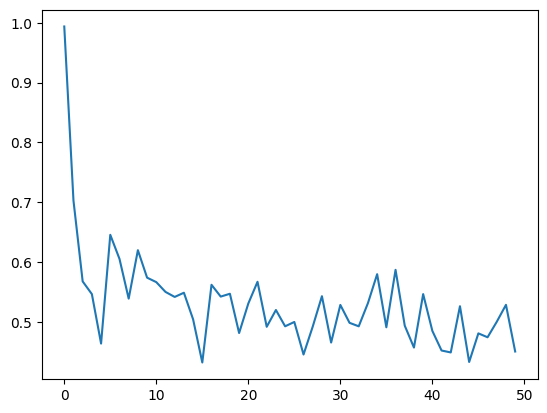

In [159]:
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(50, -1).mean(1).cpu())

In [ ]:
# Predict previously unseen instances
y_pred = clf.predict(test_embeddings.cpu())
evaluate_performance(data["test"]["label"], y_pred)

In [160]:
y_pred = []
for i, text in enumerate(data['test']['text']):
    with torch.no_grad():
        if i % 500 == 0: print(i)
        tokens = enc.encode(f"'{text}'. This move review is")
        x = torch.tensor(tokens).to('cuda')
        x = x.view(1, len(tokens))
        y = classifier(x)
        pred = F.sigmoid(y).cpu()
        y_pred.append(0 if pred < 0.5 else 1)

0
500
1000


In [161]:
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.80      0.77      0.78       533
Positive Review       0.78      0.81      0.79       533

       accuracy                           0.79      1066
      macro avg       0.79      0.79      0.79      1066
   weighted avg       0.79      0.79      0.79      1066

